C:\Users\balaz\AppData\Local\Temp\ipykernel_100860\1454247198.py:166: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)  # Fill initial NaN from rolling
C:\Users\balaz\AppData\Local\Temp\ipykernel_100860\1454247198.py:395: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\balaz\AppData\Local\Temp\ipykernel_100860\1454247198.py:396: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
C:\Users\balaz\AppData\Local\Temp\ipykernel_100860\1454247198.py:402: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['fed_funds_rate

Added 92 technical indicators
Using cuda device
Logging to ./sac_trading_tensorboard/SAC_25
---------------------------------
| time/              |          |
|    episodes        | 1        |
|    fps             | 47       |
|    time_elapsed    | 1676     |
|    total_timesteps | 80133    |
| train/             |          |
|    actor_loss      | 8.61     |
|    critic_1_loss   | 0        |
|    critic_loss     | 0.519    |
|    ent_coef        | 0.0162   |
|    ent_coef_loss   | -0.776   |
|    learning_rate   | 0.001    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 2        |
|    fps             | 47       |
|    time_elapsed    | 3387     |
|    total_timesteps | 160266   |
| train/             |          |
|    actor_loss      | 8.02     |
|    critic_1_loss   | 0        |
|    critic_loss     | 0.543    |
|    ent_coef        | 0.0225   |
|    ent_coef_loss   | 0.0756   |
|    learning_rate   | 0

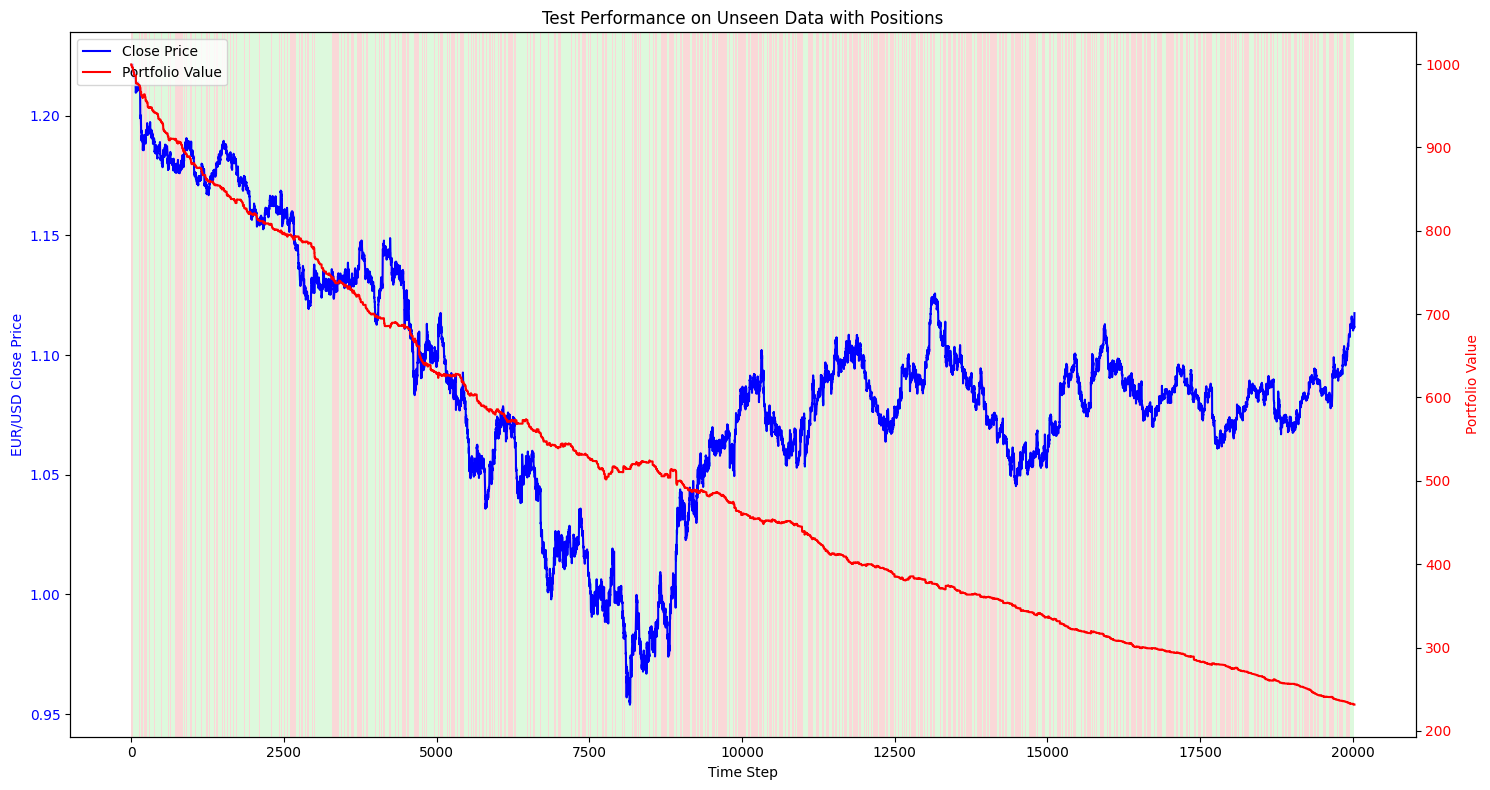

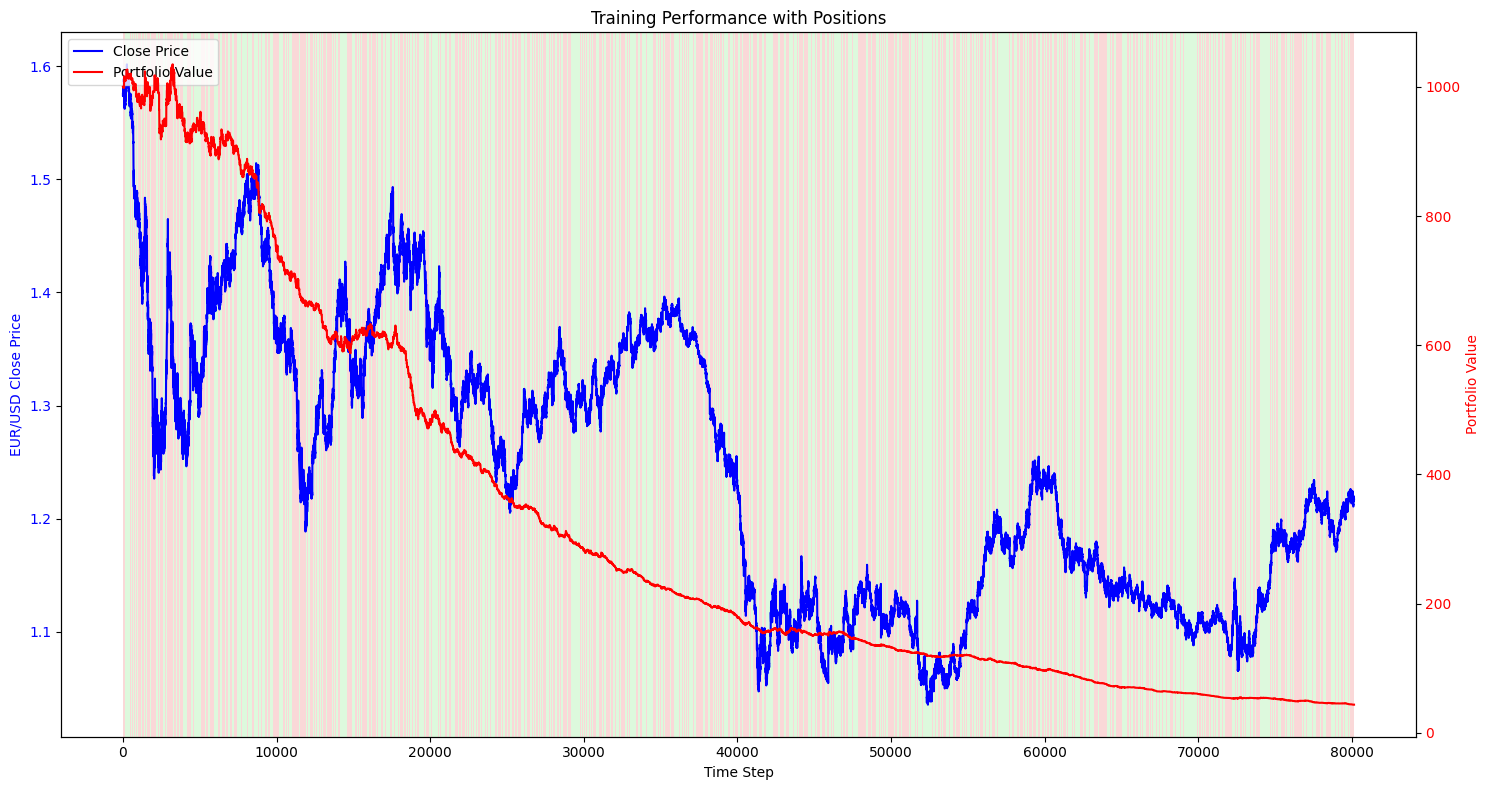

In [ ]:
import gym
import numpy as np
import pandas as pd
from datetime import datetime
import torch

from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.logger import Figure
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import TensorBoardOutputFormat
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
plt.ion()  # Turn on interactive mode
%matplotlib inline
import talib

import os

from stable_baselines3.common.callbacks import BaseCallback


################################################################################

#0. Model configuration

################################################################################

import torch.nn as nn

class TradingConfig:
    def __init__(self,
                 random_seed=42,
                 test_size=0.2,
                 sequence_length=32,
                 window_size=1,  # Added this parameter
                 initial_balance=1000.0,
                 buffer_size=30,  # This is for the returns buffer in the env
                 total_timesteps=1000000,
                 learning_rate=3e-4,
                 batch_size=256,
                 replay_buffer_size=100000,  # This is for SAC's replay buffer
                 learning_starts=1000,
                 gamma=0.99,
                 net_arch=[256, 256],
                 device="cuda",
                 activation_fn="leaky_relu",
                 slippage_rate=0.000001,
                 transaction_cost_rate=0.0000001,
                 leverage=1,
                 base_position_fraction=1):
        
        # Data preprocessing
        self.test_size = test_size
        self.sequence_length = sequence_length
        self.window_size = window_size  # Added this line
        
        # Environment
        self.initial_balance = initial_balance
        self.buffer_size = buffer_size
        self.slippage_rate = slippage_rate
        self.transaction_cost_rate = transaction_cost_rate
        self.leverage = leverage
        self.base_position_fraction = base_position_fraction
        
        # Training
        self.total_timesteps = total_timesteps
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.replay_buffer_size = replay_buffer_size
        self.learning_starts = learning_starts
        self.gamma = gamma
        self.device = device
        self.random_seed = random_seed
        
        # Model architecture
        self.net_arch = net_arch
        
        # Convert activation function string to actual function
        self.activation_map = {
            "tanh": nn.Tanh,
            "relu": nn.ReLU,
            "elu": nn.ELU,
            "leaky_relu": nn.LeakyReLU
        }
        
        if activation_fn not in self.activation_map:
            raise ValueError(f"Activation function {activation_fn} not supported. "
                           f"Choose from {list(self.activation_map.keys())}")
            
        self.activation_fn = self.activation_map[activation_fn]



################################################################################

#1. Data Loading and Preprocessing

################################################################################

def load_and_preprocess_data(csv_file_path, test_size=0.2, sequence_length=32):
    """
    - Reads the CSV with columns:
    date,time,open,high,low,close,volume,other_volume,SPREAD
    - Creates a DataFrame with a datetime index.
    - Optionally calculates technical indicators (placeholder in code).
    - Scales features.
    - Splits into train and test sets.
    - Returns data arrays for training and testing.
    """
    # Load data
    
    try:
        # Read the main forex CSV file
        df = pd.read_csv('C:/Users/balaz/Documents/IC_Markets_data/EURUSD_H1_200806301600_202408232300date_format.csv')

        # Read the Fed funds rate CSV
        fed_data = pd.read_csv('C:/Users/balaz/Documents/IC_Markets_data/FEDFUNDS_2.csv')
        fed_data['observation_date'] = pd.to_datetime(fed_data['observation_date'])
        fed_data.set_index('observation_date', inplace=True)

        # Read the ECB rate CSV
        ecb_data = pd.read_csv('C:/Users/balaz/Documents/IC_Markets_data/ECB Data Portal_20241228020814.csv')  
        # Convert DATE and format TIME_PERIOD to datetime
        ecb_data['DATE'] = pd.to_datetime(ecb_data['DATE'])
        ecb_data['ECB_rate'] = ecb_data['ECB_rate'].astype(float)  # Ensure rate is numeric
        ecb_data.set_index('DATE', inplace=True)

        # Combine date and time columns and set as index for main data
        df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
        df.set_index('datetime', inplace=True)

        # Drop original date and time columns
        df = df.drop(['date', 'time'], axis=1)

        # Standardize column names to lowercase
        df.columns = df.columns.str.lower()

        # Resample Fed funds rate to hourly frequency and forward fill
        hourly_fed_rate = fed_data.reindex(df.index, method='ffill')
        df['fed_funds_rate'] = hourly_fed_rate['FEDFUNDS']

        # Resample ECB rate to hourly frequency and forward fill
        hourly_ecb_rate = ecb_data.reindex(df.index, method='ffill')
        df['ecb_rate'] = hourly_ecb_rate['ECB_rate']


    except Exception as e:
        print(f"Error loading CSV data: {str(e)}")
        print(f"Current working directory: {os.getcwd()}")  # Help with debugging file paths
        raise e  # Re-raise the exception for debugging


    # Sort by datetime just to be sure
    df.sort_index(inplace=True)

    # Placeholder for technical indicator calculation
    # ---------------------------------------------------------------------------------
    # Example: df['ema_10'] = ta.EMA(df['close'], timeperiod=10)  # If using TA-Lib
    # For now, let's just say we add random placeholders:
    df['tech_placeholder_1'] = df['close'].rolling(window=10).mean()  # e.g., 10-period MA
    df['tech_placeholder_2'] = df['close'].rolling(window=20).std()   # e.g., 20-period STD
    df.fillna(method='bfill', inplace=True)  # Fill initial NaN from rolling
    
    # Ensure correct data types
    for col in ['open', 'high', 'low', 'close', 'volume']:
        if col in df.columns:
            df[col] = df[col].astype(float)
    try:
        # Add time-based features
        df['hour'] = df.index.hour
        df['day_of_week'] = df.index.dayofweek

        # Cyclical transformations for time features
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
        df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
        df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

        # Session indicators for major Forex sessions
        df['asian_session'] = ((df['hour'] >= 0) & (df['hour'] < 8)).astype(int)
        df['london_session'] = ((df['hour'] >= 8) & (df['hour'] < 16)).astype(int)
        df['ny_session'] = ((df['hour'] >= 13) & (df['hour'] < 21)).astype(int)

        # Price-based indicators
        df['log_price'] = np.log(df['close']).rolling(window=10).mean()
        df['log_return'] = df['log_price'].diff().rolling(window=10).mean()

        # Separate positive and negative returns
        df['positive_return'] = df['log_return'].clip(lower=0).rolling(window=10).mean()
        df['negative_return'] = df['log_return'].clip(upper=0).rolling(window=10).mean()

        # Directional volatility
        df['up_volatility'] = df['positive_return'].rolling(window=24).std() * np.sqrt(252)
        df['down_volatility'] = df['negative_return'].rolling(window=24).std() * np.sqrt(252)

        # Momentum indicators with directional components
        momentum_periods = [24, 120, 480]  # 1d, 1w, 1m
        for period in momentum_periods:
            returns = df['close'].pct_change(periods=period)
            returns_name = f'up_momentum_{period}'
            df[returns_name] = pd.Series(returns.clip(lower=0), index=df.index).rolling(window=10).mean()
            df[f'down_momentum_{period}'] = pd.Series(returns.clip(upper=0), index=df.index).rolling(window=10).mean()

        # Directional RSI components
        rsi_periods = [6, 14, 24]
        for period in rsi_periods:
            delta = df['close'].diff()
            gain = delta.clip(lower=0).rolling(window=period).mean()
            loss = -delta.clip(upper=0).rolling(window=period).mean()
            df[f'rsi_{period}_gain'] = gain
            df[f'rsi_{period}_loss'] = loss

        # Enhanced MACD with directional components
        macd, signal, hist = talib.MACD(df['close'].values, fastperiod=12, slowperiod=26, signalperiod=9)
        df['macd'] = pd.Series(macd, index=df.index)
        df['signal'] = pd.Series(signal, index=df.index)
        df['hist'] = pd.Series(hist, index=df.index)
        df['macd_up'] = df['hist'].clip(lower=0).rolling(window=10).mean()
        df['macd_down'] = df['hist'].clip(upper=0).rolling(window=10).mean()

        # Bollinger Bands with directional pressure
        bb_upper, bb_middle, bb_lower = talib.BBANDS(
            df['close'].values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0
        )
        df['bb_upper'] = pd.Series(bb_upper, index=df.index)
        df['bb_middle'] = pd.Series(bb_middle, index=df.index)
        df['bb_lower'] = pd.Series(bb_lower, index=df.index)

        # Distance from BB bands
        df['bb_upper_distance'] = ((df['close'] - df['bb_upper']) / df['bb_middle']).rolling(window=10).mean()
        df['bb_lower_distance'] = ((df['close'] - df['bb_lower']) / df['bb_middle']).rolling(window=10).mean()

        # Mean reversion components
        df['mean_reversion_pressure'] = ((df['close'] - df['bb_middle']) / df['bb_middle']).rolling(window=10).mean()
        df['up_mean_reversion'] = df['mean_reversion_pressure'].clip(upper=0) * -1
        df['down_mean_reversion'] = df['mean_reversion_pressure'].clip(lower=0)

        # Directional volume pressure
        if 'volume' in df.columns:
            df['up_volume'] = df['volume'].where(df['close'] > df['close'].shift(1), 0).rolling(window=10).mean()
            df['down_volume'] = df['volume'].where(df['close'] < df['close'].shift(1), 0).rolling(window=10).mean()
            # On-Balance Volume
            df['obv'] = pd.Series(talib.OBV(df['close'].values, df['volume'].values), index=df.index)
            df['obv_ma'] = df['obv'].rolling(window=10).mean()

        # Price patterns
        df['higher_highs'] = (df['high'] > df['high'].shift(1)).rolling(window=10).sum()
        df['lower_lows'] = (df['low'] < df['low'].shift(1)).rolling(window=10).sum()

        # Price acceleration
        df['price_acceleration'] = df['log_return'].diff().rolling(window=10).mean()
        df['up_acceleration'] = df['price_acceleration'].clip(lower=0)
        df['down_acceleration'] = df['price_acceleration'].clip(upper=0)

        # Trend strength indicators
        adx = talib.ADX(df['high'].values, df['low'].values, df['close'].values, timeperiod=14)
        plus_di = talib.PLUS_DI(df['high'].values, df['low'].values, df['close'].values, timeperiod=14)
        minus_di = talib.MINUS_DI(df['high'].values, df['low'].values, df['close'].values, timeperiod=14)
        df['adx'] = pd.Series(adx, index=df.index).rolling(window=10).mean()
        df['trend_strength_up'] = pd.Series(plus_di, index=df.index).rolling(window=10).mean()
        df['trend_strength_down'] = pd.Series(minus_di, index=df.index).rolling(window=10).mean()

        # Pivot Points
        pivot = (df['high'] + df['low'] + df['close']) / 3
        df['pivot'] = pivot.rolling(window=20).mean()
        df['r1'] = (2 * df['pivot'] - df['low']).rolling(window=10).mean()
        df['s1'] = (2 * df['pivot'] - df['high']).rolling(window=10).mean()
        df['r2'] = (df['pivot'] + (df['high'] - df['low'])).rolling(window=10).mean()
        df['s2'] = (df['pivot'] - (df['high'] - df['low'])).rolling(window=10).mean()

        # Manual Implementation of Ichimoku Cloud
        # Tenkan-sen (Conversion Line)
        period9_high = df['high'].rolling(window=9).max()
        period9_low = df['low'].rolling(window=9).min()
        df['tenkan_sen'] = ((period9_high + period9_low) / 2).rolling(window=10).mean()

        # Kijun-sen (Base Line)
        period26_high = df['high'].rolling(window=26).max()
        period26_low = df['low'].rolling(window=26).min()
        df['kijun_sen'] = ((period26_high + period26_low) / 2).rolling(window=10).mean()

        # Senkou Span A (Leading Span A)
        df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(26).rolling(window=10).mean()

        # Senkou Span B (Leading Span B)
        period52_high = df['high'].rolling(window=52).max()
        period52_low = df['low'].rolling(window=52).min()
        df['senkou_span_b'] = ((period52_high + period52_low) / 2).shift(26).rolling(window=10).mean()

        # ATR for volatility
        atr = talib.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=14)
        df['atr'] = pd.Series(atr, index=df.index).rolling(window=10).mean()

        # Stochastic Oscillator
        slowk, slowd = talib.STOCH(
            df['high'].values,
            df['low'].values,
            df['close'].values,
            fastk_period=14,
            slowk_period=3,
            slowk_matype=0,
            slowd_period=3,
            slowd_matype=0
        )
        df['slowk'] = pd.Series(slowk, index=df.index).rolling(window=10).mean()
        df['slowd'] = pd.Series(slowd, index=df.index).rolling(window=10).mean()

        # Currency-specific strength indicators
        roc = talib.ROC(df['close'].values, timeperiod=10)
        df['price_rate_of_change'] = pd.Series(roc, index=df.index).rolling(window=10).mean()
        df['normalized_range'] = ((df['high'] - df['low']) / df['close']).rolling(window=10).mean()

        # Added Advanced Indicators
        # Exponential Moving Averages
        ema_periods = [12, 26, 50, 100, 200]
        for ema in ema_periods:
            ema_values = talib.EMA(df['close'].values, timeperiod=ema)
            df[f'ema_{ema}'] = pd.Series(ema_values, index=df.index).rolling(window=10).mean()

        # On-Balance Volume (if volume exists)
        if 'volume' in df.columns:
            obv = talib.OBV(df['close'].values, df['volume'].values)
            df['obv'] = pd.Series(obv, index=df.index)
            df['obv_ma'] = df['obv'].rolling(window=10).mean()

        # SuperTrend Indicator (Manual Implementation)
        def calculate_supertrend(df, period=10, multiplier=3):
            hl2 = (df['high'] + df['low']) / 2
            atr = talib.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)
            atr = pd.Series(atr, index=df.index)
            up = hl2 + (multiplier * atr)
            down = hl2 - (multiplier * atr)

            supertrend = pd.Series(np.nan, index=df.index)
            trend = True  # True means uptrend

            for i in range(1, len(df)):
                if pd.isna(up.iloc[i - 1]) or pd.isna(down.iloc[i - 1]):
                    continue

                if df['close'].iloc[i] > up.iloc[i - 1]:
                    trend = True
                elif df['close'].iloc[i] < down.iloc[i - 1]:
                    trend = False

                if trend:
                    supertrend.iloc[i] = down.iloc[i]
                else:
                    supertrend.iloc[i] = up.iloc[i]

            # Rolling window on SuperTrend
            supertrend = supertrend.rolling(window=1).mean()
            return supertrend

        df['supertrend'] = calculate_supertrend(df).rolling(window=10).mean()

        # Expanded Candlestick Patterns
        df['doji'] = talib.CDLDOJI(df['open'], df['high'], df['low'], df['close'])
        df['hammer'] = talib.CDLHAMMER(df['open'], df['high'], df['low'], df['close'])
        df['engulfing_bullish'] = talib.CDLENGULFING(df['open'], df['high'], df['low'], df['close'])
        df['engulfing_bearish'] = talib.CDLENGULFING(
            df['open'].shift(1),
            df['high'].shift(1),
            df['low'].shift(1),
            df['close'].shift(1)
        )
        # Convert to binary features
        df['doji'] = (df['doji'] != 0).astype(int).rolling(window=10).max()
        df['hammer'] = (df['hammer'] != 0).astype(int).rolling(window=10).max()
        df['engulfing_bullish'] = (df['engulfing_bullish'] > 0).astype(int)
        df['engulfing_bearish'] = (df['engulfing_bearish'] < 0).astype(int)

        # Volatility breakout indicators
        df['volatility_breakout_up'] = (
            ((df['close'] - df['close'].rolling(window=20).mean()) / df['close'].rolling(window=20).std())
            .clip(lower=0)
            .rolling(window=10)
            .mean()
        )
        df['volatility_breakout_down'] = (
            ((df['close'] - df['close'].rolling(window=20).mean()) / df['close'].rolling(window=20).std())
            .clip(upper=0)
            .rolling(window=10)
            .mean()
        )

        # Replace infinite values with NaN
        df.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Forward fill and backward fill NaN values
        df.fillna(method='ffill', inplace=True)
        df.fillna(method='bfill', inplace=True)
        
        # Add Fed funds rate change as additional feature
        df['fed_funds_rate_change'] = df['fed_funds_rate'].diff()

        # Handle any NaN values in the new features
        df['fed_funds_rate'] = df['fed_funds_rate'].fillna(method='ffill')
        df['fed_funds_rate_change'] = df['fed_funds_rate_change'].fillna(0)
        
        # Add ECB rate change as additional feature
        df['ecb_rate_change'] = df['ecb_rate'].diff()

        # Handle any NaN values in the new features
        df['ecb_rate'] = df['ecb_rate'].fillna(method='ffill')
        df['ecb_rate_change'] = df['ecb_rate_change'].fillna(0)
        
        # Calculate the rate differential (optional but potentially useful feature)
        df['rate_differential'] = df['ecb_rate'] - df['fed_funds_rate']

        print(f"Added {len(df.columns)} technical indicators")
        
    except Exception as e:
        print(f"Error adding technical indicators: {str(e)}")
        print(f"Current columns: {df.columns.tolist()}")
        raise e

  
    # ---------------------------------------------------------------------------------

    # Features to use (you might add more indicators)
    features = ['open', 'high', 'low', 'close', 'volume', 
                'tech_placeholder_1', 'tech_placeholder_2',
                "hour_sin","hour_cos","day_of_week_sin","day_of_week_cos",
                "asian_session","london_session","ny_session","log_price","log_return","positive_return",
                "negative_return","up_volatility","down_volatility","up_momentum_24","up_momentum_120",
                "up_momentum_480", "down_momentum_24", "down_momentum_120", "down_momentum_480",
                "rsi_6_gain", "rsi_6_loss","rsi_14_gain","rsi_14_loss", "rsi_24_gain","rsi_24_loss",
                "macd", "signal", "hist", "macd_up", "macd_down", "bb_upper","bb_middle","bb_lower",
                "bb_upper_distance","bb_lower_distance","mean_reversion_pressure","up_mean_reversion",
                "down_mean_reversion", "up_volume", "down_volume", "obv", "obv_ma", "higher_highs",
                "lower_lows", "price_acceleration","up_acceleration","down_acceleration","adx",
                "trend_strength_up","trend_strength_down","pivot","r1","s1","r2","s2","tenkan_sen",
                "kijun_sen", "senkou_span_a","senkou_span_b","atr","slowk","slowd","price_rate_of_change",
                "normalized_range", "ema_12", "ema_26", "ema_50","ema_100","ema_200","supertrend","doji",
                "hammer","engulfing_bullish","engulfing_bearish","volatility_breakout_up",
                "volatility_breakout_down", 'fed_funds_rate_change', 'fed_funds_rate', 
                'ecb_rate_change', 'ecb_rate', 'rate_differential']

    data = df[features].copy()

    # Scale features
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Convert to numpy arrays
    data_np = np.array(data_scaled, dtype=np.float32)
    close_prices = df['close'].values  # For reference with reward

    # Train-test split by ratio
    split_index = int((1 - test_size) * len(data_np))
    train_data = data_np[:split_index]
    test_data = data_np[split_index:]

    train_close = close_prices[:split_index]
    test_close = close_prices[split_index:]

    return (train_data, train_close), (test_data, test_close), scaler

##################################################################

#2. Create a Custom Gym Environment

################################################################################

class FXTradingEnv(gym.Env):
    def __init__(self, data, close_prices, config):
        super(FXTradingEnv, self).__init__()
        
        self.data = data
        self.close_prices = close_prices
        self.window_size = config.window_size
        
        self.forward_window = 5  # Number of hours to look ahead
        
        # Store the length of the data
        self.max_steps = len(self.data) - self.forward_window  # Adjust max steps to account for forward window
        
        # Action space: continuous between -1 and 1
        # Where: -1 to 0 represents short positions (0 to 100% of available capital)
        #         0 represents no position
        #         0 to 1 represents long positions (0 to 100% of available capital)
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        
        # Observation space
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, 
            shape=(self.data.shape[1] + 1,),
            dtype=np.float32
        )
        
        # Internal states
        self._current_step = 0
        self._holding_position = 0
        self._entry_price = 0.0
        self._returns_buffer = []
        self._buffer_size = config.buffer_size
        
        # Portfolio tracking
        self.initial_balance = config.initial_balance
        self._net_worth = self.initial_balance
        self._realized_pnl = 0.0
        
        # Trading params
        self.slippage_rate = config.slippage_rate
        self.transaction_cost_rate = config.transaction_cost_rate
        self.leverage = config.leverage
        self.base_position_fraction = config.base_position_fraction

    def reset(self):
        """
        Resets the environment to an initial state.
        """
        self._current_step = 0
        self._holding_position = 0
        self._entry_price = self.close_prices[self._current_step]
        self._returns_buffer = []
        self._net_worth = self.initial_balance
        self._realized_pnl = 0.0

        return self._get_observation()

    def step(self, action):
        # Convert action from shape (1,) to scalar
        action = action[0]

        # Determine position direction and size based on continuous action
        if action > 0:  # Long position
            position_direction = 1
            position_size_fraction = action  # e.g., 0.78 means 78% of available capital
        elif action < 0:  # Short position
            position_direction = -1
            position_size_fraction = abs(action)  # e.g., -0.65 means 65% of available capital short
        else:  # No position (action = 0)
            position_direction = 0
            position_size_fraction = 0

        # Calculate position size based on the fraction
        new_position_size = self._net_worth * position_size_fraction * self.leverage

        # Get current price and calculate execution price with slippage
        current_price = self.close_prices[self._current_step]

        # Calculate execution price with slippage based on direction
        if position_direction == 1:  # Long
            execution_price = current_price * (1.0 + self.slippage_rate)
        elif position_direction == -1:  # Short
            execution_price = current_price * (1.0 - self.slippage_rate)
        else:
            execution_price = current_price

        # Close existing position if direction changes
        if self._holding_position != position_direction:
            if self._holding_position != 0:
                # Calculate PnL from closing existing position
                if self._holding_position == 1:  # Closing long position
                    close_price = current_price * (1.0 - self.slippage_rate)
                    pnl = (close_price - self._entry_price) * self._entry_size
                else:  # Closing short position
                    close_price = current_price * (1.0 + self.slippage_rate)
                    pnl = (self._entry_price - close_price) * self._entry_size

                # Apply transaction costs
                close_cost = self.transaction_cost_rate * (close_price * self._entry_size)
                self._realized_pnl += pnl - close_cost

                # Reset position
                self._holding_position = 0
                self._entry_price = 0.0
                self._entry_size = 0.0

        # Open new position if direction is not zero
        if position_direction != 0 and self._holding_position != position_direction:
            self._holding_position = position_direction
            self._entry_price = execution_price
            self._entry_size = new_position_size

            # Apply transaction costs for opening new position
            open_cost = self.transaction_cost_rate * (execution_price * self._entry_size)
            self._realized_pnl -= open_cost

        # Update net worth
        self._net_worth = self.initial_balance + self._realized_pnl

        # Calculate forward returns for reward
        forward_returns = self.close_prices[self._current_step + 1:self._current_step + self.forward_window + 1]
        forward_returns = np.diff(forward_returns) / forward_returns[:-1]

        if len(forward_returns) > 0:
            mean_return = np.mean(forward_returns)
            std_return = np.std(forward_returns) + 1e-6

            # Reward based on position and forward Sharpe, scaled by position size
            if self._holding_position != 0:
                reward = (mean_return / std_return) * position_size_fraction * self._holding_position
            else:
                reward = 0
        else:
            reward = 0

        # Prepare observation for next step
        self._current_step += 1
        done = self._current_step >= self.max_steps
        obs = self._get_observation()

        info = {
            'net_worth': self._net_worth,
            'realized_pnl': self._realized_pnl,
            'current_price': current_price,
            'holding_position': self._holding_position,
            'position_size': self._entry_size if self._holding_position != 0 else 0,
            'position_fraction': position_size_fraction,
            'forward_sharpe': mean_return / std_return if len(forward_returns) > 0 else 0
        }

        return obs, reward, done, info


    def _get_observation(self):
        """
        Returns the current observation. 
        We'll flatten the features at current_step plus current holding_position.
        """
        obs = self.data[self._current_step]
        obs = np.append(obs, [self._holding_position])
        return obs

    def render(self, mode='human'):
        """
        For demonstration, we won't implement visualization here.
        """
        pass


################################################################################

#3. Training and Evaluation

################################################################################

def make_env(data, close, config):
    """
    Utility function to instantiate the environment.
    """
    return FXTradingEnv(data, close, config)


def plot_training_metrics(callback, save_directory='training_results'):
    """
    Plot SAC training metrics evolution
    """
    print(f"Number of data points - Episode Rewards: {len(callback.episode_rewards)}, "
          f"Critic 1 Loss: {len(callback.critic_1_loss)}")  # Debug info
    
    # Create the save directory if it doesn't exist
    os.makedirs(save_directory, exist_ok=True)
    
    if len(callback.episode_rewards) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('SAC Training Metrics Evolution', fontsize=16)

        # Plot Episode Rewards (main metric)
        axes[0, 0].plot(callback.episode_rewards, label='Episode Reward', color='blue', alpha=0.3)
        if len(callback.rolling_reward) > 0:
            axes[0, 0].plot(callback.rolling_reward, label='100-episode Rolling Average', 
                           color='red', linewidth=2)
        axes[0, 0].set_title('Episode Rewards Over Time')
        axes[0, 0].set_xlabel('Episodes')
        axes[0, 0].set_ylabel('Reward')
        axes[0, 0].grid(True)
        axes[0, 0].legend()

        # Plot Critic Loss if available
        if len(callback.critic_1_loss) > 0:
            axes[0, 1].plot(callback.critic_1_loss, label='Critic 1 Loss', color='blue', alpha=0.7)
            # Plot combined critic loss if available
            if len(callback.critic_loss) > 0:
                axes[0, 1].plot(callback.critic_loss, label='Critic Loss', color='red', alpha=0.7)
            axes[0, 1].set_title('Critics Loss')
            axes[0, 1].set_xlabel('Steps')
            axes[0, 1].set_ylabel('Loss')
            axes[0, 1].grid(True)
            axes[0, 1].legend()

        # Plot Actor Loss if available
        if len(callback.actor_loss) > 0:
            axes[1, 0].plot(callback.actor_loss, label='Actor Loss', color='green')
            axes[1, 0].set_title('Actor Loss')
            axes[1, 0].set_xlabel('Steps')
            axes[1, 0].set_ylabel('Loss')
            axes[1, 0].grid(True)
            axes[1, 0].legend()

        # Plot Entropy Coefficient if available
        if len(callback.entropy_coefficient_value) > 0:
            axes[1, 1].plot(callback.entropy_coefficient_value, label='Entropy Coefficient', color='purple')
            axes[1, 1].set_title('Entropy Coefficient')
            axes[1, 1].set_xlabel('Steps')
            axes[1, 1].set_ylabel('Value')
            axes[1, 1].grid(True)
            axes[1, 1].legend()

        plt.tight_layout()
        plt.savefig(os.path.join(save_directory, "training_metrics_plots.png"))
        plt.show()
        plt.close()

        # Create DataFrame with available metrics
        metrics_dict = {'episode_reward': callback.episode_rewards}
        if len(callback.rolling_reward) > 0:
            metrics_dict['rolling_reward'] = callback.rolling_reward
        if len(callback.critic_1_loss) > 0:
            metrics_dict['critic_1_loss'] = callback.critic_1_loss
        if len(callback.critic_loss) > 0:
            metrics_dict['critic_loss'] = callback.critic_loss
        if len(callback.actor_loss) > 0:
            metrics_dict['actor_loss'] = callback.actor_loss
        if len(callback.entropy_coefficient_value) > 0:
            metrics_dict['entropy_coefficient'] = callback.entropy_coefficient_value
        
        metrics_df = pd.DataFrame(metrics_dict)
        metrics_df.to_csv(os.path.join(save_directory, "training_metrics.csv"), index=False)
        
        # Print summary statistics
        print("\nTraining Summary Statistics:")
        print(f"Total episodes: {len(callback.episode_rewards)}")
        if len(callback.episode_rewards) >= 100:
            print(f"Final 100-episode average reward: {np.mean(callback.episode_rewards[-100:]):.2f}")
        else:
            print(f"Final episode average reward: {np.mean(callback.episode_rewards):.2f}")
        
        if len(callback.rolling_reward) > 0:
            print(f"Best 100-episode average reward: {np.max(callback.rolling_reward):.2f}")
        
        if len(callback.entropy_coefficient_value) > 0:
            print(f"Final entropy coefficient value: {callback.entropy_coefficient_value[-1]:.4f}")
        
    else:
        print("No training metrics data available to plot")

            
def train_rl(csv_file_path, config=None):
    # Use default config if none provided
    if config is None:
        config = TradingConfig()
        
    # Set all random seeds
    import random
    random.seed(config.random_seed)
    np.random.seed(config.random_seed)
    torch.manual_seed(config.random_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(config.random_seed)
        torch.cuda.manual_seed_all(config.random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
    # Load data
    (train_data, train_close), (test_data, test_close), scaler = load_and_preprocess_data(
        csv_file_path, test_size=config.test_size
    )
    
    # Create training environment
    train_env = make_env(train_data, train_close, config)
    train_env = DummyVecEnv([lambda: train_env])
    
  
    # Create model (PPO) with logging
    model = SAC(
        "MlpPolicy",
        train_env,
        verbose=1,
        learning_rate=config.learning_rate,
        batch_size=config.batch_size,
        buffer_size=100000,  # replay buffer size
        learning_starts=1000,
        gamma=config.gamma,
        device=config.device,
        seed=config.random_seed,
        policy_kwargs={
            "net_arch": config.net_arch,
            "activation_fn": config.activation_fn
        },
        tensorboard_log="./sac_trading_tensorboard/"
    )
    
    # Create a callback to track training metrics
    training_metrics = []
    

    class CustomCallback(BaseCallback):
        def __init__(self, verbose=0):
            super(CustomCallback, self).__init__(verbose)
            self.critic_1_loss = []
            self.critic_loss = []  # If you want to track combined critic loss
            self.actor_loss = []
            self.entropy_coefficient_loss = []
            self.entropy_coefficient_value = []
            self.episode_rewards = []  # Ensure your environment provides this info
            self.rolling_reward = []
            self.current_episode_reward = 0

        def _on_step(self) -> bool:
            # Capture available metrics
            try:
                critic_1_loss = self.logger.name_to_value["train/critic_1_loss"]
                self.critic_1_loss.append(critic_1_loss)
            except KeyError:
                pass

            try:
                critic_loss = self.logger.name_to_value["train/critic_loss"]
                self.critic_loss.append(critic_loss)
            except KeyError:
                pass

            try:
                actor_loss = self.logger.name_to_value["train/actor_loss"]
                self.actor_loss.append(actor_loss)
            except KeyError:
                pass

            try:
                ent_coef_loss = self.logger.name_to_value["train/ent_coef_loss"]
                self.entropy_coefficient_loss.append(ent_coef_loss)
            except KeyError:
                pass

            try:
                ent_coef = self.logger.name_to_value["train/ent_coef"]
                self.entropy_coefficient_value.append(ent_coef)
            except KeyError:
                pass

            # Handle rewards
            info = self.locals.get("infos", [{}])
            if info is not None:
                for item in info:
                    if "episode" in item:
                        episode_info = item["episode"]
                        ep_len = episode_info["l"]
                        ep_rew = episode_info["r"]
                        self.current_episode_reward += ep_rew
                        if item.get("done", False):
                            self.episode_rewards.append(self.current_episode_reward)
                            self.current_episode_reward = 0
                            if len(self.episode_rewards) >= 100:
                                self.rolling_reward.append(np.mean(self.episode_rewards[-100:]))
                            else:
                                self.rolling_reward.append(np.mean(self.episode_rewards))

            return True  # Continue training


    
    callback = CustomCallback()
    
    # Train model with callback
    model.learn(
        total_timesteps=config.total_timesteps, 
        callback=callback,
        log_interval=1  # Log every step
    )

    
    # Plot training metrics
    plot_training_metrics(callback)
    
    # Force display of plots
    plt.show()
    
    # Evaluate on Test Set
    test_env_instance = make_env(test_data, test_close, config)
    df_test_results, df_test_trades = evaluate_model(model, test_env_instance)
    test_metrics = compute_metrics(df_test_results, df_test_trades)
    
    # Print Test Metrics
    print("\n=== Test Set Metrics ===")
    for key, value in test_metrics.items():
        if value is not None:
            print(f"{key}: {value:.4f}")
        else:
            print(f"{key}: N/A")
    
    # Evaluate on Training Set
    train_env_instance = make_env(train_data, train_close, config)
    df_train_results, df_train_trades = evaluate_model(model, train_env_instance)
    train_metrics = compute_metrics(df_train_results, df_train_trades)
    
    # Print Training Metrics
    print("\n=== Training Set Metrics ===")
    for key, value in train_metrics.items():
        if value is not None:
            print(f"{key}: {value:.4f}")
        else:
            print(f"{key}: N/A")

            
    # Plot Test Results with Combined Chart
    plot_combined_chart(df_test_results, "Test Performance on Unseen Data with Positions")
    
    # Plot Training Results with Combined Chart
    plot_combined_chart(df_train_results, "Training Performance with Positions")

    return model, df_train_results, df_test_results, test_env_instance, train_env_instance, callback


# Function to plot combined chart with background colors
def plot_combined_chart(df_results, title):
    """
    Plots EUR/USD Close Price and Portfolio Value on a single chart with background colors
    indicating the agent's position (long, short, hold).

    Args:
        df_results: DataFrame containing step-wise performance data.
        title: Title of the plot.
    """
    plt.figure(figsize=(15, 8))
    
    # Define colors for positions
    position_colors = {1: 'lightgreen', -1: 'lightcoral', 0: 'lightgrey'}
    
    # Create twin y-axes
    ax1 = plt.gca()
    ax1.set_title(title)
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('EUR/USD Close Price', color='blue')
    ax1.plot(df_results['step'], df_results['close_price'], color='blue', label='Close Price')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Portfolio Value', color='red')
    ax2.plot(df_results['step'], df_results['net_worth'], color='red', label='Portfolio Value')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Plot background colors based on position
    previous_pos = df_results['holding_position'].iloc[0]
    start_idx = df_results['step'].iloc[0]
    for i in range(1, len(df_results)):
        current_pos = df_results['holding_position'].iloc[i]
        if current_pos != previous_pos:
            ax1.axvspan(start_idx, df_results['step'].iloc[i],
                       facecolor=position_colors.get(previous_pos, 'lightgrey'), alpha=0.3)
            start_idx = df_results['step'].iloc[i]
            previous_pos = current_pos
    # Fill the last segment
    ax1.axvspan(start_idx, df_results['step'].iloc[-1],
               facecolor=position_colors.get(previous_pos, 'lightgrey'), alpha=0.3)
    
    # Add legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
    
    plt.tight_layout()
    plt.show()


def evaluate_model(model, env):
    """
    Args:
        model: Trained RL model.
        env: Gym environment to evaluate on.

    Returns:
        df_results: DataFrame containing step-wise performance data.
        trades_df: DataFrame containing details of each trade, 
                   including whether it was a long or short trade.
    """
    obs = env.reset()
    done = False

    # Lists to store results
    step_list = []
    net_worth_list = []
    close_price_list = []
    actions_list = []
    holding_positions = []
    forward_sharpes = []

    # Lists to track trades
    trades = []
    trade_entry_price = None
    trade_entry_worth = None
    trade_type = None  # will be 'long' or 'short' (or possibly flat)

    step_count = 0

    # Access initial_balance correctly for vectorized environments
    if isinstance(env, DummyVecEnv):
        initial_balance = env.get_attr('initial_balance')[0]
    else:
        initial_balance = env.initial_balance

    previous_net_worth = initial_balance

    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)

        # Handle info depending on if env is vectorized
        if isinstance(env, DummyVecEnv):
            # Retrieve the first environment's info (assuming single environment vectorization)
            info = info[0]

        current_net_worth = info['net_worth']
        step_pnl = current_net_worth - previous_net_worth  # Calculate step PnL

        # Collect data for df_results
        step_list.append(step_count)
        net_worth_list.append(current_net_worth)
        close_price_list.append(info['current_price'])
        actions_list.append(action)
        holding_positions.append(info['holding_position'])
        forward_sharpes.append(info['forward_sharpe'])

        # Track trades: if the holding position changes, we close the old trade and open a new one
        if (trade_entry_price is None) or (trade_type != info['holding_position']):
            # Close the previous trade if it exists
            if trade_entry_price is not None:
                trade_pnl = current_net_worth - trade_entry_worth
                trades.append({
                    'entry_price': trade_entry_price,
                    'exit_price': info['current_price'],
                    'pnl': trade_pnl,
                    'trade_type': trade_type,
                    'action': action
                })

            # Open a new trade
            trade_entry_price = info['current_price']
            trade_entry_worth = current_net_worth
            trade_type = info['holding_position']

        previous_net_worth = current_net_worth
        step_count += 1

    # Create DataFrame for results
    df_results = pd.DataFrame({
        "step": step_list,
        "net_worth": net_worth_list,
        "close_price": close_price_list,
        "action": actions_list,
        "holding_position": holding_positions,
        "forward_sharpe": forward_sharpes
    })

    # Calculate step-wise PnL
    df_results['pnl'] = df_results['net_worth'].diff()
    # Set first row PnL as the difference from initial balance
    df_results.loc[0, 'pnl'] = df_results.loc[0, 'net_worth'] - initial_balance

    # Create DataFrame for trades
    trades_df = pd.DataFrame(trades)
    # Only include completed trades with valid pnl
    trades_df = trades_df.dropna(subset=['pnl'])

    return df_results, trades_df


def compute_metrics(df_results, trades_df):
    """
    Computes performance metrics from results.
    """
    trading_days_per_year = 252

    # Calculate CAGR
    start_value = df_results['net_worth'].iloc[0]
    # Adjust index to avoid out-of-bounds if your dataset is shorter than 50 steps
    end_idx = min(len(df_results) - 1, len(df_results) - 50)  
    end_value = df_results['net_worth'].iloc[end_idx]

    n_years = len(df_results) / (trading_days_per_year * 24)  # Adjusting for hourly data
    cagr = (end_value / start_value) ** (1 / n_years) - 1 if (start_value > 0 and n_years > 0) else 0.0
    total_simple_return = end_value / start_value - 1 if start_value > 0 else 0.0

    # Calculate Maximum Drawdown
    roll_max = df_results['net_worth'].cummax()
    drawdowns = (df_results['net_worth'] - roll_max) / roll_max
    max_drawdown = abs(drawdowns.min())

    # Calculate daily (hourly) returns and annualized volatility
    df_results['hourly_return'] = df_results['net_worth'].pct_change().fillna(0)
    annual_volatility = df_results['hourly_return'].std() * np.sqrt(trading_days_per_year * 24)

    # Sharpe Ratio calculation
    risk_free_rate = 0.02  # Assuming 2% risk-free rate
    if annual_volatility != 0:
        excess_returns = cagr - risk_free_rate
        sharpe_ratio = excess_returns / annual_volatility
    else:
        sharpe_ratio = 0.0

    # Basic trade stats
    number_of_trades = len(trades_df)
    
    # Calculate price changes between consecutive steps
    df_results['price_change'] = df_results['close_price'].diff()

    
    # === Metrics based on all steps (df_results) ===
    # Count number of steps in each position type
    total_long_steps = len(df_results[df_results['holding_position'] == 1])
    total_short_steps = len(df_results[df_results['holding_position'] == -1])
    total_neutral_steps = len(df_results[df_results['holding_position'] == 0])
    total_steps = total_long_steps + total_short_steps + total_neutral_steps

    # Calculate PnL for each position type
    long_steps_pnl = df_results[df_results['holding_position'] == 1]['pnl'].sum()
    short_steps_pnl = df_results[df_results['holding_position'] == -1]['pnl'].sum()
    
    # Calculate win rates based on step-wise PnL
    long_winning_steps = len(df_results[(df_results['holding_position'] == 1) & (df_results['price_change'] > 0)])
    short_winning_steps = len(df_results[(df_results['holding_position'] == -1) & (df_results['price_change'] < 0)])
    
    long_step_win_rate = long_winning_steps / total_long_steps if total_long_steps > 0 else 0.0
    short_step_win_rate = short_winning_steps / total_short_steps if total_short_steps > 0 else 0.0
    total_step_win_rate = (long_winning_steps + short_winning_steps) / total_steps

    # === Original metrics based on closed trades (trades_df) ===
    number_of_trades = len(trades_df)
    profitable_trades = trades_df[trades_df['pnl'] > 0]
    unprofitable_trades = trades_df[trades_df['pnl'] < 0]
    closed_trades_win_rate = len(profitable_trades) / number_of_trades if number_of_trades > 0 else 0.0
    mean_pnl_profitable_trades = profitable_trades['pnl'].mean()
    mean_pnl_unprofitable_trades = unprofitable_trades['pnl'].mean()
    median_pnl_profitable_trades = profitable_trades['pnl'].median()
    median_pnl_unprofitable_trades = unprofitable_trades['pnl'].median()
    
    # Long-short ratio
    long_short_ratio = (total_long_steps / (total_short_steps + total_long_steps + total_neutral_steps)) if (total_short_steps + total_long_steps + total_neutral_steps) > 0 else 0.0

    # For long recall: steps where price went up
    price_up_steps = df_results[df_results['price_change'] > 0]
    if len(price_up_steps) > 0:
        long_recall_numerator = len(price_up_steps[
            (price_up_steps['holding_position'] == 1) &  # was in long position
            (price_up_steps['price_change'] > 0)                  # had positive PnL
        ])
        long_recall = long_recall_numerator / len(price_up_steps)
    else:
        long_recall = 0.0

    # For short recall: steps where price went down
    price_down_steps = df_results[df_results['price_change'] < 0]
    if len(price_down_steps) > 0:
        short_recall_numerator = len(price_down_steps[
            (price_down_steps['holding_position'] == -1) &  # was in short position
            (price_down_steps['price_change'] < 0)                   # had positive PnL
        ])
        short_recall = short_recall_numerator / len(price_down_steps)
    else:
        short_recall = 0.0
        
        
    True_positives =  len(df_results[(df_results['holding_position'] == 1) & (df_results['price_change'] > 0)])
    False_positive = len(df_results[(df_results['holding_position'] == 1) & (df_results['price_change'] < 0)])
    True_negatives =  len(df_results[(df_results['holding_position'] == -1) & (df_results['price_change'] < 0)])
    False_negative = len(df_results[(df_results['holding_position'] == -1) & (df_results['price_change'] > 0)])
    
    
    # Calculate F1 score for long
    if (long_step_win_rate + long_recall) != 0:
        f1_score_long = 2 * (long_step_win_rate * long_recall) / (long_step_win_rate + long_recall)
    else:
        f1_score_long = 0.0

    # Calculate F1 score for Short
    if (short_step_win_rate + short_recall) != 0:
        f1_score_short = 2 * (short_step_win_rate * short_recall) / (short_step_win_rate + short_recall)
    else:
        f1_score_short = 0.0


    metrics = {
        "CAGR": cagr,
        "Sharpe Ratio": sharpe_ratio,
        "Maximum Drawdown": max_drawdown,
        "Annual Volatility": annual_volatility,
        "Start Value": start_value,
        "End Value": end_value,
        "Total Holding Period Return": total_simple_return,
        "Number of Trades (open + closed positions)": total_steps,
        "Number of Long Trades (open + closed positions)": total_long_steps,
        "Number of Short Trades (open + closed positions)": total_short_steps,
        "Long-Short Ratio (open + closed positions)": long_short_ratio,
        "Precision (Overall, open + closed positions)": total_step_win_rate,
        "Precision (Long, open + closed positions)": long_step_win_rate,
        "Precision (Short, open + closed positions)": short_step_win_rate,
        "Recall (Long, open + closed positions)": long_recall,
        "Recall (Short, open + closed positions)": short_recall,
        'True_positives':  True_positives,
        'False_positives': False_positive,
        'True_negatives':  True_negatives,
        'False_negatives': False_negative,
        'F1 score (Long)': f1_score_long,
        'F1 score (Short)':  f1_score_short,
        # Closed trades metrics
        'Number_of_closed_trades': number_of_trades,
        'Closed_trades_win_rate': closed_trades_win_rate,
        'Mean pnl - profitable trades': mean_pnl_profitable_trades,
        'Mean pnl - unprofitable trades': mean_pnl_unprofitable_trades,
        'Median pnl - profitable trades': median_pnl_profitable_trades,
        'Median pnl - unprofitabletrades': median_pnl_unprofitable_trades,

    }

    return metrics


def save_model_and_metrics(model, df_train_results, df_test_results, metrics_test, metrics_train, config, base_directory="C:/Users/balaz/Documents/TRADING/01_Code/01_Drafts/EURUSD/RL_v08/saved_models", callback=None):
    # Get the current date
    current_datetime = datetime.now().strftime("%Y%m%d_%H%M")

    # Create a directory with the current date within the base directory
    save_directory = os.path.join(base_directory, f"saved_model_{current_datetime}")
    os.makedirs(save_directory, exist_ok=True)
    
    # Save the trained model
    model.save(os.path.join(save_directory, "trained_model"))
    
    # Save the results DataFrames
    df_train_results.to_csv(os.path.join(save_directory, "train_results.csv"))
    df_test_results.to_csv(os.path.join(save_directory, "test_results.csv"))
    
    # Save configuration
    config_dict = vars(config)
    with open(os.path.join(save_directory, "config.txt"), 'w') as f:
        for key, value in config_dict.items():
            f.write(f"{key}: {value}\n")
    
    # Save metrics to separate CSV files
    pd.DataFrame([metrics_train]).to_csv(os.path.join(save_directory, "metrics_train.csv"))
    pd.DataFrame([metrics_test]).to_csv(os.path.join(save_directory, "metrics_test.csv"))
    
#     # Save training metrics from callback if provided
#     if callback is not None:
#         # Find the maximum length among all metrics
#         max_len = max(
#             len(callback.loss),
#             len(callback.value_loss),
#             len(callback.policy_loss),
#             len(callback.entropy)
#         )
        
#         # Pad shorter arrays with NaN values to match the maximum length
#         training_metrics_df = pd.DataFrame({
#             'episode_reward': callback.episode_rewards + [float('nan')] * (max_len - len(callback.episode_rewards)),
#             'rolling_reward': callback.rolling_reward + [float('nan')] * (max_len - len(callback.rolling_reward)),
#             'critic_1_loss': callback.critic_1_loss + [float('nan')] * (max_len - len(callback.critic_1_loss)),
#             'critic_2_loss': callback.critic_2_loss + [float('nan')] * (max_len - len(callback.critic_2_loss)),
#             'actor_loss': callback.actor_loss + [float('nan')] * (max_len - len(callback.actor_loss)),
#             'alpha_value': callback.alpha_value + [float('nan')] * (max_len - len(callback.alpha_value))
#         })
        
#         training_metrics_df.to_csv(os.path.join(save_directory, "training_metrics.csv"))

#         # Save training metrics plots
#         if len(callback.episode_rewards) > 0:
#             fig, axes = plt.subplots(2, 2, figsize=(15, 12))
#             fig.suptitle('SAC Training Metrics Evolution', fontsize=16)

#             # Plot Episode Rewards (main metric)
#             axes[0, 0].plot(callback.episode_rewards, label='Episode Reward', color='blue', alpha=0.3)
#             if len(callback.rolling_reward) > 0:
#                 axes[0, 0].plot(callback.rolling_reward, label='100-episode Rolling Average', color='red', linewidth=2)
#             axes[0, 0].set_title('Episode Rewards Over Time')
#             axes[0, 0].set_xlabel('Episodes')
#             axes[0, 0].set_ylabel('Reward')
#             axes[0, 0].grid(True)
#             axes[0, 0].legend()

#             # Plot Critics Loss
#             if len(callback.critic_1_loss) > 0:
#                 axes[0, 1].plot(callback.critic_1_loss, label='Critic 1 Loss', color='blue', alpha=0.7)
#             if len(callback.critic_loss) > 0:
#                 axes[0, 1].plot(callback.critic_loss, label='Critic Loss', color='red', alpha=0.7)
#             axes[0, 1].set_title('Critics Loss')
#             axes[0, 1].set_xlabel('Steps')
#             axes[0, 1].set_ylabel('Loss')
#             axes[0, 1].grid(True)
#             axes[0, 1].legend()

#             # Plot Actor Loss
#             if len(callback.actor_loss) > 0:
#                 axes[1, 0].plot(callback.actor_loss, label='Actor Loss', color='green')
#             axes[1, 0].set_title('Actor Loss')
#             axes[1, 0].set_xlabel('Steps')
#             axes[1, 0].set_ylabel('Loss')
#             axes[1, 0].grid(True)
#             axes[1, 0].legend()

#             # Plot Entropy Coefficient
#             if len(callback.entropy_coefficient_value) > 0:
#                 axes[1, 1].plot(callback.entropy_coefficient_value, label='Entropy Coefficient', color='purple')
#             axes[1, 1].set_title('Entropy Coefficient')
#             axes[1, 1].set_xlabel('Steps')
#             axes[1, 1].set_ylabel('Value')
#             axes[1, 1].grid(True)
#             axes[1, 1].legend()

#             plt.tight_layout()
#             plt.savefig(os.path.join(save_directory, "training_metrics_plots.png"))
#             plt.close()

    
    print(f"Model and results saved in '{save_directory}' directory")
    return save_directory


if __name__ == "__main__":
    csv_file_path = 'C:/Users/balaz/Documents/IC_Markets_data/EURUSD_H1_200806301600_202408232300date_format.csv'
    
    # Create custom config
    config = TradingConfig(
        random_seed=42,
        test_size=0.2,
        sequence_length=32,
        window_size=1,  # Added this parameter
        initial_balance=1000.0,
        buffer_size=30,
        total_timesteps=500000,
        learning_rate=1e-3,
        batch_size=256,
        replay_buffer_size=100000,   #100000
        learning_starts=1000,  #1000
        gamma=0.99,
        net_arch=[256, 256],
        device="cuda",
        activation_fn="leaky_relu",
        slippage_rate=0.0001,
        transaction_cost_rate=0.0003,
        leverage=1,
        base_position_fraction=1
    )


    

    # Modify the train_rl function to return all necessary components
    trained_model, df_train_results, df_test_results, test_env_instance, train_env_instance, callback = train_rl(csv_file_path, config)
    
    # Evaluate the model using the test environment already created
    df_results_test, trades_df_test = evaluate_model(trained_model, test_env_instance)
    df_results_train, trades_df_train = evaluate_model(trained_model, train_env_instance)
    
    metrics_test = compute_metrics(df_results_test, trades_df_test)
    metrics_train = compute_metrics(df_results_train, trades_df_train)
    
    # Save everything
    # With this:
    save_model_and_metrics(
        model=trained_model,
        df_train_results=df_train_results,
        df_test_results=df_test_results,
        metrics_test=metrics_test,
        metrics_train=metrics_train,
        config=config,
        base_directory="C:/Users/balaz/Documents/TRADING/01_Code/01_Drafts/EURUSD/RL_v08/saved_models", 
        callback=callback
    )




In [ ]:
############################# LOAD THE MODEL AND TEST WITH DIFFERENT PARAMS  ######################################

C:\Users\balaz\AppData\Local\Temp\ipykernel_104576\1149171392.py:166: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)  # Fill initial NaN from rolling
C:\Users\balaz\AppData\Local\Temp\ipykernel_104576\1149171392.py:395: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\balaz\AppData\Local\Temp\ipykernel_104576\1149171392.py:396: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
C:\Users\balaz\AppData\Local\Temp\ipykernel_104576\1149171392.py:402: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['fed_funds_rate

Added 92 technical indicators
{'CAGR': -0.08161761371657383, 'Sharpe Ratio': -0.535670586000857, 'Maximum Drawdown': 0.26127406859369545, 'Annual Volatility': 0.18970168676838878, 'Start Value': 999.999957542611, 'End Value': 868.524721396009, 'Total Holding Period Return': -0.1314752417286975, 'Number of Trades (open + closed positions)': 10013, 'Number of Long Trades (open + closed positions)': 7147, 'Number of Short Trades (open + closed positions)': 2866, 'Long-Short Ratio (open + closed positions)': 0.7137720962748427, 'Win Rate (Overall, open + closed positions)': 0.4946569459702387, 'Win Rate (Long, open + closed positions)': 0.49629215055267945, 'Win Rate (Short, open + closed positions)': 0.49057920446615494, 'Long Recall (open + closed positions)': 0.0156469408224674, 'Short Recall (open + closed positions)': 0.028953229398663696, 'Number_of_closed_trades': 2408, 'Closed_trades_win_rate': 0.5095514950166113, 'Mean pnl - profitable trades': 1.9831144057519214, 'Mean pnl - unpr

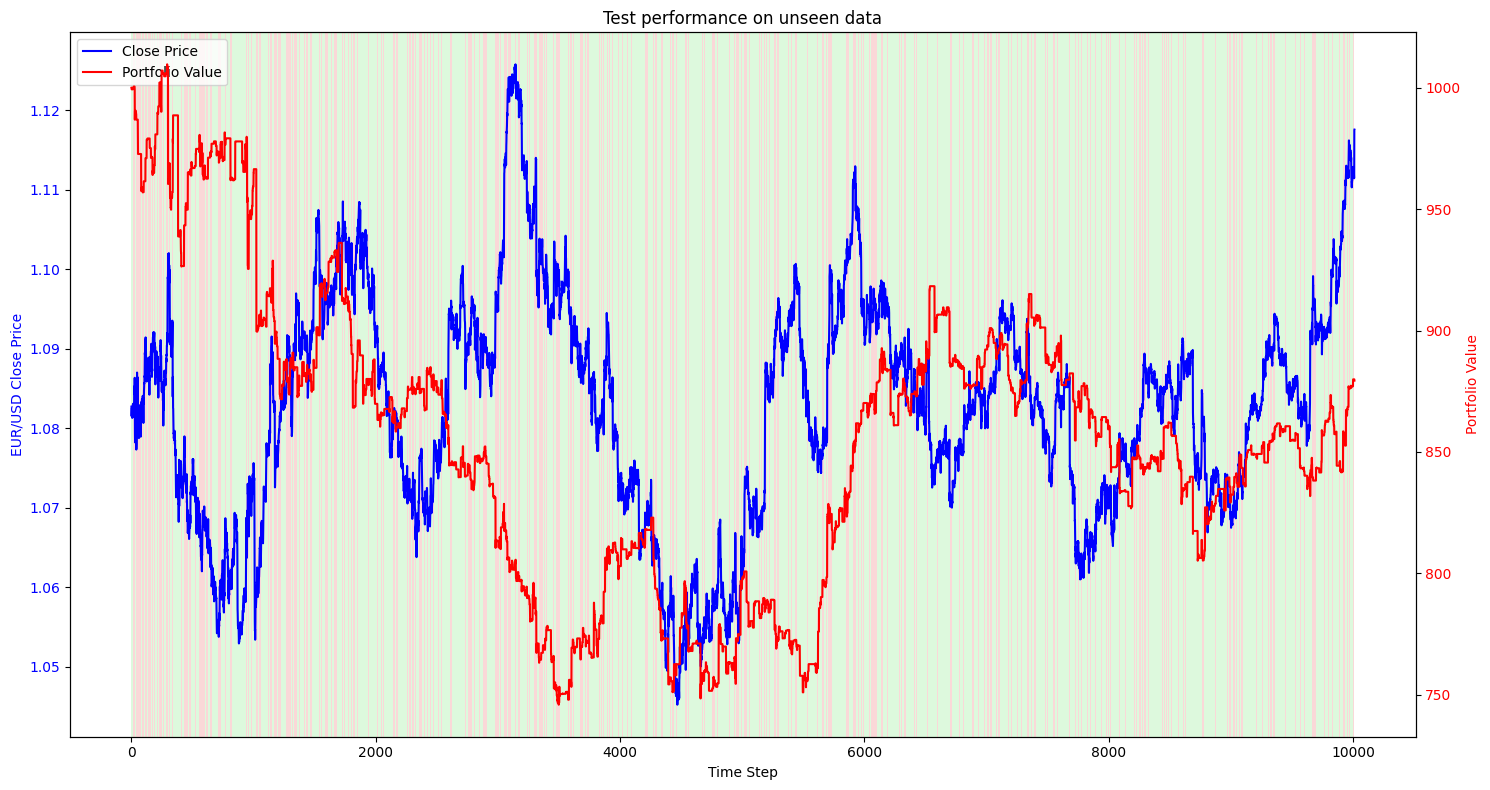

In [2]:
import torch
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# Assuming the following functions and classes are defined in your current setup:
# - load_and_preprocess_data()
# - make_env()
# - evaluate_model()
# - TradingConfig

test_size_modified = 0.1

# Load the saved model
saved_model_path = "C:/Users/balaz/Documents/TRADING/01_Code/01_Drafts/EURUSD/RL_v08/saved_models/saved_model_20250102_1232/trained_model.zip"
model = SAC.load(saved_model_path)


# Load and preprocess data for testing
csv_file_path = 'C:/Users/balaz/Documents/IC_Markets_data/EURUSD_H1_200806301600_202408232300date_format.csv'
(train_data, train_close), (test_data, test_close), scaler = load_and_preprocess_data(csv_file_path, test_size=test_size_modified)

# Create a new config with modified parameters
modified_config = TradingConfig(
        test_size=test_size_modified,
        initial_balance=1000.0, 
        device="cuda",
        slippage_rate = 0.000001,
        transaction_cost_rate = 0.0000001,
        leverage = 5,
        base_position_fraction = 1
    )


# Create a new test environment with the modified config
test_env = make_env(test_data, test_close, modified_config)
test_env = DummyVecEnv([lambda: test_env])

# Evaluate the model on the new test environment
df_results_test, trades_df_test = evaluate_model(model, test_env)

# Compute and display metrics
metrics_test = compute_metrics(df_results_test, trades_df_test)
print(metrics_test)

title = 'Test performance on unseen data'
# Plot performance
plot_combined_chart(df_results_test, title)


In [2]:
trades_df_test

,entry_price,exit_price,pnl,trade_type,action
0,1.21827,1.21777,-0.458673,1,[-0.5493994]
1,1.21777,1.21735,0.229252,-1,[0.7472944]
2,1.21735,1.21700,-0.263349,1,[-0.05163139]
3,1.21700,1.21854,-0.079742,-1,[0.95274544]
4,1.21854,1.21740,-1.088045,1,[-0.12269342]
...,...,...,...,...,...
4274,1.11132,1.11261,0.231761,1,[-0.39724183]
4275,1.11261,1.11230,0.130469,-1,[0.2223283]
4276,1.11230,1.11173,-0.135966,1,[-0.60276085]
4277,1.11173,1.11142,0.198063,-1,[0.118980646]


In [3]:
df_results_test

,step,net_worth,close_price,action,holding_position,forward_sharpe,pnl,hourly_return,price_change
0,0,999.999958,1.08272,[[0.078427196]],1,0.921599,-0.000042,0.000000,NaN
1,1,999.528199,1.08152,[[-0.5631088]],-1,-0.076416,-0.471759,-0.000472,-0.00120
2,2,999.352832,1.08158,[[0.07191169]],1,-0.423327,-0.175366,-0.000175,0.00006
3,3,999.352832,1.08220,[[0.601161]],1,-0.226489,0.000000,0.000000,0.00062
4,4,999.352832,1.08253,[[0.39800632]],1,-0.164492,0.000000,0.000000,0.00033
...,...,...,...,...,...,...,...,...,...
10008,10008,879.874792,1.11191,[[-0.43043602]],-1,0.575622,0.000000,0.000000,-0.00006
10009,10009,879.874792,1.11142,[[-0.44972968]],-1,0.787059,0.000000,0.000000,-0.00049
10010,10010,879.874792,1.11149,[[-0.25199306]],-1,0.343971,0.000000,0.000000,0.00007
10011,10011,879.874792,1.11749,[[-0.5264988]],-1,0.442821,0.000000,0.000000,0.00600


In [5]:
df_results_train

,step,net_worth,close_price,action,holding_position,forward_sharpe,pnl,hourly_return,price_change
0,0,999.999876,1.57570,[0.789132],1,-0.017356,-0.000124,0.000000,NaN
1,1,999.999876,1.57440,[0.96970487],1,0.365143,0.000000,0.000000,-0.00130
2,2,999.999876,1.57350,[0.93718195],1,-0.182202,0.000000,0.000000,-0.00090
3,3,999.999876,1.57590,[0.9864578],1,-0.066874,0.000000,0.000000,0.00240
4,4,999.999876,1.57500,[0.85987794],1,0.542411,0.000000,0.000000,-0.00090
...,...,...,...,...,...,...,...,...,...
80128,80128,29228.801667,1.21797,[-0.33602345],-1,-0.281713,0.000000,0.000000,-0.00034
80129,80129,29228.801667,1.21794,[-0.9875837],-1,-0.258214,0.000000,0.000000,-0.00003
80130,80130,29228.801667,1.21773,[-0.1918034],-1,0.023115,0.000000,0.000000,-0.00021
80131,80131,29230.353822,1.21771,[0.55439615],1,0.648220,1.552156,0.000053,-0.00002
